# Determining What Makes for a Successfully Funded Kickstarter

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import sklearn as sk
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sns
from datetime import datetime

## Data Source

### https://www.kaggle.com/kemical/kickstarter-projects

## Import & View Data

In [2]:
ks = pd.read_csv("ks-projects-201801.csv")
ks.head()

/Users/Ryan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning:

Columns (13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.



,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01 03:43:57,30000,2017-09-02 04:43:57,2421,failed,15,US,100,NaN,NaN,NaN,NaN
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,NaN
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN


In [3]:
ks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378648 entries, 0 to 378647
Data columns (total 17 columns):
ID               378648 non-null int64
name             378644 non-null object
category         378648 non-null object
main_category    378648 non-null object
currency         378648 non-null object
deadline         378648 non-null object
goal             378648 non-null object
launched         378648 non-null object
pledged          378648 non-null object
state            378648 non-null object
backers          378648 non-null object
country          378648 non-null object
usd pledged      374858 non-null object
Unnamed: 13      713 non-null object
Unnamed: 14      13 non-null object
Unnamed: 15      5 non-null object
Unnamed: 16      1 non-null float64
dtypes: float64(1), int64(1), object(15)
memory usage: 49.1+ MB


### This data set consists of entries for a large number of fundraising ventures on the popular website Kickstarter. Attributes include the name of the project, the desired money amount, the category of the venture, and more. Utilizing these attributes, we will be predicting what makes for a successfully funded Kickstarter project.

## Clean Data

### Remove empty columns

In [4]:
ks = ks.iloc[:,0:13]

### Drop rows with invalid 'main_category'

In [5]:
valid_categories = ["Music", "Film & Video", "Games", "Publishing", "Art", "Design", "Theater",
                    "Technology", "Food", "Comics", "Fashion", "Photography", "Dance", "Crafts",
                    "Journalism"]
ks = ks[ks["main_category"].isin(valid_categories)]

### Drop rows with invalid 'currency'

In [6]:
valid_currencies = ["AUD", "CAD", "CHF", "DKK", "EUR", "GBP", "HKD", "JPY", "MXN", "NOK", "NZD",
                    "SEK", "SGD", "USD"]
ks = ks[ks["currency"].isin(valid_currencies)]

In [7]:
ks["currency"].unique()

array(['GBP', 'USD', 'CAD', 'AUD', 'NOK', 'EUR', 'MXN', 'SEK', 'NZD',
       'CHF', 'DKK', 'HKD', 'SGD', 'JPY'], dtype=object)

### Remove projects with the "state" of "undefined"; they were never finished to begin with and contain NA values

In [8]:
state_undefined = ks[ks["state"] == "undefined"].index
ks.drop(state_undefined, inplace = True)

### Update entries with no "country" value with a country of "none"

In [9]:
ks[ks["country"] == "N,\"0"] = "none"

### Update entries with no "name" value with a name of "none"

In [10]:
ks["name"] = ks["name"].fillna("none")

### Convert launch and deadline dates with a value of "none" to arbitrary date for processing

In [11]:
ks["launched"][ks["launched"] == "none"] = "1990-01-01 01:00:00"

### Convert launch and deadline columns to datetime format

In [12]:
ks["launched"] =  pd.to_datetime(ks["launched"], format = "%Y-%m-%d %H:%M:%S", errors = "coerce")
ks["deadline"] = pd.to_datetime(ks["deadline"], format = "%Y-%m-%d %H:%M:%S", errors = "coerce")

### Replace resulting NA values with arbitrary date

In [13]:
ks["launched"].fillna("1990-01-01 01:00:00", inplace = True)
ks["deadline"].fillna("1990-01-01 01:00:00", inplace = True)

### Convert launch and deadline columns to datetime format again to conert previously NA values

In [14]:
ks["launched"] =  pd.to_datetime(ks["launched"], format = "%Y-%m-%d %H:%M:%S")
ks["deadline"] = pd.to_datetime(ks["deadline"], format = "%Y-%m-%d %H:%M:%S")

### Split datatime columns into year, month, and day

In [15]:
ks["launched_y"] = pd.to_numeric(ks["launched"].astype("str").str.slice(0, 4))
ks["launched_m"] = pd.to_numeric(ks["launched"].astype("str").str.slice(5, 7))

ks["deadline_y"] = pd.to_numeric(ks["deadline"].astype("str").str.slice(0, 4))
ks["deadline_m"] = pd.to_numeric(ks["deadline"].astype("str").str.slice(5, 7))

### Drop old datetime columns

In [16]:
ks = ks.drop("launched", 1)
ks = ks.drop("deadline", 1)

### Drop entries with strings in 'backers'

In [17]:
ks["backers"] = pd.to_numeric(ks["backers"], errors = "coerce")
ks["backers"].dropna(inplace = True)

### Drop entries with strings in 'usd pledged'

In [18]:
ks["usd pledged"] = pd.to_numeric(ks["usd pledged"], errors = "coerce")
ks["usd pledged"].dropna(inplace = True)

### Create dummy variable for if a project is succesful

In [19]:
ks["funded"] = np.where(ks["state"] == "successful", 1, 0)

### Check ratio of successful vs unsuccessful projects

In [20]:
ks.groupby("funded")["funded"].count()

funded
0    240712
1    133661
Name: funded, dtype: int64

### Reset index of data frame

In [21]:
ks.reset_index(drop = True, inplace = True)

### Check for any residual NA values and drop those rows

In [22]:
null_data = ks[ks.isnull().any(axis=1)]
null_data.head()

,ID,name,category,main_category,currency,goal,pledged,state,backers,country,usd pledged,launched_y,launched_m,deadline_y,deadline_m,funded
2425,none,none,none,none,none,none,none,none,NaN,none,NaN,1990,1,1990,1,0
4284,none,none,none,none,none,none,none,none,NaN,none,NaN,1990,1,1990,1,0
4835,none,none,none,none,none,none,none,none,NaN,none,NaN,1990,1,1990,1,0
5290,none,none,none,none,none,none,none,none,NaN,none,NaN,1990,1,1990,1,0
5532,none,none,none,none,none,none,none,none,NaN,none,NaN,1990,1,1990,1,0


In [23]:
ks.dropna(inplace = True)

### View final data frame

In [24]:
ks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374138 entries, 0 to 374372
Data columns (total 16 columns):
ID               374138 non-null object
name             374138 non-null object
category         374138 non-null object
main_category    374138 non-null object
currency         374138 non-null object
goal             374138 non-null object
pledged          374138 non-null object
state            374138 non-null object
backers          374138 non-null float64
country          374138 non-null object
usd pledged      374138 non-null float64
launched_y       374138 non-null int64
launched_m       374138 non-null int64
deadline_y       374138 non-null int64
deadline_m       374138 non-null int64
funded           374138 non-null int64
dtypes: float64(2), int64(5), object(9)
memory usage: 48.5+ MB


In [25]:
ks.head()

,ID,name,category,main_category,currency,goal,pledged,state,backers,country,usd pledged,launched_y,launched_m,deadline_y,deadline_m,funded
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,1000,0,failed,0.0,GB,0.0,2015,8,2015,10,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,30000,2421,failed,15.0,US,100.0,2017,9,2017,11,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,45000,220,failed,3.0,US,220.0,2013,1,2013,2,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,5000,1,failed,1.0,US,1.0,2012,3,2012,4,0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,19500,1283,canceled,14.0,US,1283.0,2015,7,2015,8,0


## Question I: Which category is successfully funded with the highest frequency?

### Get count of each main category by amount of succesful fundings and view the results

In [26]:
ks_funded = ks[ks["funded"] == 1]
f_tab = ks_funded[["main_category", "funded"]]
f_tab["tot_funded"] = ks_funded["main_category"].groupby(ks_funded["main_category"]).transform("size")
f_tab = f_tab.sort_values(by = ["tot_funded"], ascending = False)
f_tab = f_tab.drop_duplicates(keep = "first")
f_tab

/Users/Ryan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,main_category,funded,tot_funded
153389,Music,1,24079
226595,Film & Video,1,23593
174335,Games,1,12501
349494,Publishing,1,12271
251563,Art,1,11485
374356,Design,1,10537
64382,Theater,1,6526
147789,Technology,1,6426
1708,Food,1,6070
326883,Comics,1,5832


### Plot the results

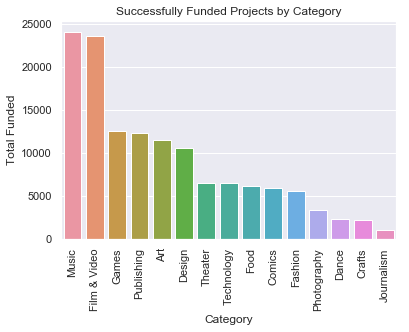

In [27]:
sns.set()
f_plot = sns.barplot(f_tab["main_category"], f_tab["tot_funded"])
f_plot.set_xticklabels(f_plot.get_xticklabels(), rotation = 90);
plt.title("Successfully Funded Projects by Category")
f_plot.set(xlabel = "Category", ylabel = "Total Funded")
plt.show()

### As we can see, Music projects appear to have the most successfully funded projects at 24,171 followed closely by Film & Video at 23,604, before there is a rather steep dropoff to Games at 12,501.

## Question II: Which category has the best chance of getting successfully funded?

### In order to calculate the frequency of a category being funded, we will now subset the data to all of the projects of each category that were not succcessfully funded so as to create a ratio

In [28]:
ks_nfunded = ks[ks["funded"] == 0]

In [29]:
n_tab = ks_nfunded[["main_category", "funded"]]
n_tab["tot_nfunded"] = ks_nfunded["main_category"].groupby(ks_nfunded["main_category"]).transform("size")
n_tab = n_tab.sort_values(by = ["tot_nfunded"], ascending = False)
n_tab = n_tab.drop_duplicates(keep = "first")
n_tab

/Users/Ryan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,main_category,funded,tot_nfunded
315162,Film & Video,0,39019
114747,Publishing,0,26963
222557,Technology,0,26082
48985,Music,0,25373
303204,Games,0,22678
80480,Design,0,19478
32685,Food,0,18475
297049,Fashion,0,17188
169151,Art,0,16593
115986,Photography,0,7451


### Get count of each main category by amount of unsuccesful fundings and view the results

In [30]:
n_tab = ks_nfunded[["main_category", "funded"]]
n_tab["tot_not_funded"] = ks_nfunded["main_category"].groupby(ks_nfunded["main_category"]).transform("size")
n_tab = n_tab.sort_values(by=["tot_not_funded"], ascending=False)
n_tab = n_tab.drop_duplicates(keep = "first")
n_tab = n_tab.reset_index()
n_tab

/Users/Ryan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,index,main_category,funded,tot_not_funded
0,315162,Film & Video,0,39019
1,114747,Publishing,0,26963
2,222557,Technology,0,26082
3,48985,Music,0,25373
4,303204,Games,0,22678
5,80480,Design,0,19478
6,32685,Food,0,18475
7,297049,Fashion,0,17188
8,169151,Art,0,16593
9,115986,Photography,0,7451


### Re-sort successfully funded projects by category

In [31]:
f_tab = f_tab.sort_values(by = ["main_category"], ascending = True)
f_tab = f_tab.reset_index()
f_tab

,index,main_category,funded,tot_funded
0,251563,Art,1,11485
1,326883,Comics,1,5832
2,59066,Crafts,1,2113
3,278581,Dance,1,2335
4,374356,Design,1,10537
5,354845,Fashion,1,5582
6,226595,Film & Video,1,23593
7,1708,Food,1,6070
8,174335,Games,1,12501
9,286263,Journalism,1,1011


### Create new ratio table from previous tables, engineer percentage of success by dividing succesful projects by total projects


In [32]:
ratio_table = f_tab
ratio_table["tot_not_funded"] = n_tab["tot_not_funded"]

ratio_table["percent"] = ratio_table["tot_funded"] / (ratio_table["tot_funded"] + ratio_table["tot_not_funded"])
ratio_table

,index,main_category,funded,tot_funded,tot_not_funded,percent
0,251563,Art,1,11485,39019,0.227408
1,326883,Comics,1,5832,26963,0.177832
2,59066,Crafts,1,2113,26082,0.074942
3,278581,Dance,1,2335,25373,0.084272
4,374356,Design,1,10537,22678,0.317236
5,354845,Fashion,1,5582,19478,0.222745
6,226595,Film & Video,1,23593,18475,0.560830
7,1708,Food,1,6070,17188,0.260985
8,174335,Games,1,12501,16593,0.429676
9,286263,Journalism,1,1011,7451,0.119475


### Re-sort funded projects by percent of successful fundings

In [33]:
ratio_table = ratio_table.sort_values(by=["percent"], ascending=False)

### Plot the categories by percent sucess rate

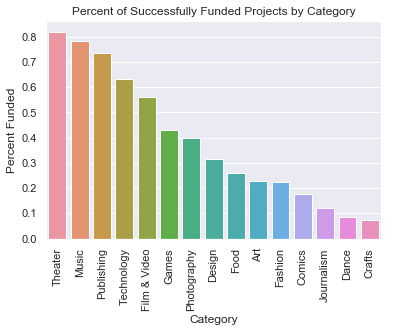

In [34]:
sns.set()
r_plot = sns.barplot(ratio_table["main_category"], ratio_table["percent"])
r_plot.set_xticklabels(r_plot.get_xticklabels(), rotation = 90);
plt.title("Percent of Successfully Funded Projects by Category")
r_plot.set(xlabel = "Category", ylabel = "Percent Funded")
plt.show()

### It appears that, compared to the total number of instances for each category, Dance Kickstarters have the highest chance of success at 62.5% followed by Theater at 60.2% and Comics at 54.4%.

## Predictive Modeling

### Encode data

In [35]:
ks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374138 entries, 0 to 374372
Data columns (total 16 columns):
ID               374138 non-null object
name             374138 non-null object
category         374138 non-null object
main_category    374138 non-null object
currency         374138 non-null object
goal             374138 non-null object
pledged          374138 non-null object
state            374138 non-null object
backers          374138 non-null float64
country          374138 non-null object
usd pledged      374138 non-null float64
launched_y       374138 non-null int64
launched_m       374138 non-null int64
deadline_y       374138 non-null int64
deadline_m       374138 non-null int64
funded           374138 non-null int64
dtypes: float64(2), int64(5), object(9)
memory usage: 48.5+ MB


In [36]:
ks["ID"] = ks["ID"].astype("category").cat.codes
ks["name"] = ks["name"].astype("category").cat.codes
ks["category"] = ks["category"].astype("category").cat.codes
ks["main_category"] = ks["main_category"].astype("category").cat.codes
ks["currency"] = ks["currency"].astype("category").cat.codes
ks["goal"] = ks["goal"].astype("category").cat.codes
ks["pledged"] = ks["pledged"].astype("category").cat.codes
ks["state"] = ks["state"].astype("category").cat.codes
ks["country"] = ks["country"].astype("category").cat.codes

### Check results

In [37]:
ks.head()

,ID,name,category,main_category,currency,goal,pledged,state,backers,country,usd pledged,launched_y,launched_m,deadline_y,deadline_m,funded
0,173782,322416,108,12,5,7,0,1,0.0,9,0.0,2015,8,2015,10,0
1,173783,131460,93,6,13,3905,24879,1,15.0,21,100.0,2017,9,2017,11,0
2,173784,353661,93,6,13,5321,22362,1,3.0,21,220.0,2013,1,2013,2,0
3,173785,334185,90,10,13,5725,1,1,1.0,21,1.0,2012,3,2012,4,0
4,173786,75728,55,6,13,2402,7554,0,14.0,21,1283.0,2015,7,2015,8,0


### Split data into test and train sets and drop unwanted attributes

In [38]:
ks = ks.drop("ID", 1)
ks = ks.drop("name", 1)
ks = ks.drop("state", 1)

In [39]:
ks.head()

,category,main_category,currency,goal,pledged,backers,country,usd pledged,launched_y,launched_m,deadline_y,deadline_m,funded
0,108,12,5,7,0,0.0,9,0.0,2015,8,2015,10,0
1,93,6,13,3905,24879,15.0,21,100.0,2017,9,2017,11,0
2,93,6,13,5321,22362,3.0,21,220.0,2013,1,2013,2,0
3,90,10,13,5725,1,1.0,21,1.0,2012,3,2012,4,0
4,55,6,13,2402,7554,14.0,21,1283.0,2015,7,2015,8,0


In [40]:
X = ks[["category", "main_category", "currency", "goal", "pledged", "backers", "country",
       "usd pledged", "launched_y", "launched_m", "deadline_y", "deadline_m"]].values
y = ks["funded"].values

### Split data into train and test sets

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 151)

### Perform feature scaling

In [42]:
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

### Create Logistic Regression model

In [43]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state = 151)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_pred

/Users/Ryan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



array([0, 1, 0, ..., 0, 0, 0])

### Print model accuracy

In [44]:
from sklearn import metrics

print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.7950852866376168


### Check model precision and recall

In [45]:
print("Precision: ", metrics.precision_score(y_test, y_pred))
print("Recall: ", metrics.recall_score(y_test, y_pred))

Precision:  0.8397473133894859
Recall:  0.5254907306434023


### Check model confusion matrix

In [46]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm

array([[75036,  4414],
       [20886, 23130]])

### Create Random Forest model

In [47]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 1000)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

### Check model accuracy

In [48]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9341195146842045


### Check model precision and recall

In [49]:
print("Precision: ", metrics.precision_score(y_test, y_pred))
print("Recall: ", metrics.recall_score(y_test, y_pred))

Precision:  0.9070653900258656
Recall:  0.9082606324972737


### Check model confusion matrix

In [50]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[75354,  4096],
       [ 4038, 39978]])

### Determine feature importance

In [51]:
feature_names = list(ks.drop(["funded"], axis = 1).columns)
feature_imp = pd.Series(clf.feature_importances_, index = feature_names).sort_values(ascending = False)
feature_imp

backers          0.352436
usd pledged      0.220432
goal             0.142995
pledged          0.109745
category         0.040462
main_category    0.037673
launched_m       0.022007
deadline_m       0.021962
deadline_y       0.020208
launched_y       0.017459
country          0.007513
currency         0.007108
dtype: float64

### Plot results

No handles with labels found to put in legend.


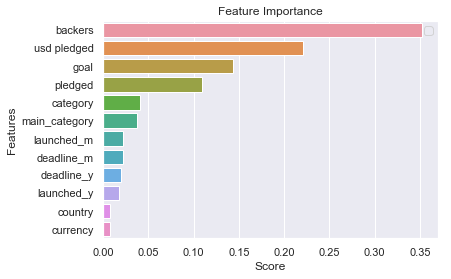

<Figure size 432x288 with 0 Axes>

In [62]:
%matplotlib inline
sns_plot = sns.barplot(x = feature_imp, y = feature_imp.index)
plt.xlabel("Score")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.legend()
plt.show()

### Remove unimportant features for refined model

In [63]:
X = ks[["goal", "pledged", "backers", "usd pledged"]].values
y = ks["funded"].values

### Split data into train and test sets

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 151)

### Perform feature scaling

In [65]:
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

### Create refined Random Forest model

In [66]:
clf_r = RandomForestClassifier(n_estimators = 1000)

clf_r.fit(X_train, y_train)
y_pred = clf_r.predict(X_test)

### Check model accuracy

In [67]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9612524905642039


### Check model precision and recall

In [68]:
print("Precision: ", metrics.precision_score(y_test, y_pred))
print("Recall: ", metrics.recall_score(y_test, y_pred))

Precision:  0.9440822240333243
Recall:  0.9474282079243911


### Check model confusion matrix

In [69]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[76980,  2470],
       [ 2314, 41702]])